# Sentiment analysis

Sentiment analysis is a NLP technique to determine the sentiment of a sentence. In this implementation, we will focuse on determining the sentiment of the subject of the subject or object or the sentence.

Here I propose some possible sentences for our dataset, indicating where the meaning is encoded.

- Sensitive man cries. (sensitive)
- Irascible woman shouts. (irascible)
- Frightened woman shouts. (frightened)
- Kid laughs. (laughs)
- Kid is cheerful. (cheerful)
- Man is gloomy. (gloomy)
- Young woman is furious. (furious)
- Old man is terrified. (terrified)
- Young man snaps. (snaps)
- Kid startles old man. (startles)
- Young woman grieves man. (grieves)
...


| Nouns | Verbs | Adjectives |
| --- | --- | --- |
| Man | is | sensitive |
| Woman | laughs | irascible |
| Kid | cries | frightened |
|  | shouts | cheerful |
|  | snaps | gloomy |
|  | grieves | furius |
|  | startles | terrified |
|  |  | old |
|  |  | young |

The proposed vocabulary has 19 words and three different kind of sentences:
- (Adj +) Subject + Verb
- (Adj +) Subject + Verb + (Adj +) Object
- (Adj +) Subject + Verb + Adj

## 1. Create dataset

The first step is to create a dataset using the presented vocabulary. We have to store the words in DisCoPy's Word objects, encoding their meaning (name) and their grammar (codomain). Then, we introduce the grammar of the allowed sentences and create all the possible grammatical sentences. The next step is to assign a sentiment to each sentence. However, there are sentences that although they are grammatically correct, their meaning makes no sense, so we would have to remove them. 

### 1.1. Define the vocabulary

The first step to create a dataset is to define the words, their meaning and the word type. We have four three types of words: nouns, adjectives, verbs. We also distinguish three different types of verbs: transitive, intransitive and attributive. In the case of the attributive verbs ('is' in our vocabulary) we are going to treat the sentence as a noun, as discussed in https://arxiv.org/pdf/1904.03478.pdf. This makes sense as the attributive verbs are a special type of verbs that are used to attribute a quality to the subject of the sentence. For example, the sentence 'woman is gloomy' has the same meaning as 'gloomy woman', so we can consider it as a noun. As we are aware of this, we will directly create this adj + noun constructs to account for the attributive sentences, so we will not create a Word accounting for the verb 'is'.

In [1]:
import numpy as np
import pickle

In [2]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s and n
nphr, adj, tv, iv, vphr = Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP')

# Define the words (notice that we include both meaning and grammar)

# nouns
man, woman, kid = Word('man', n), Word('woman', n), Word('kid', n)
# adjectives
sensitive, irascible = Word('sensitive', n @ n.l), Word('irascible', n @ n.l)
frightened, cheerful = Word('frightened', n @ n.l), Word('cheerful', n @ n.l)
gloomy, furious = Word('gloomy', n @ n.l), Word('furious', n @ n.l)
terrified, old = Word('terrified', n @ n.l), Word('old', n @ n.l)
young = Word('young', n @ n.l)
# Intransitive verbs
cries, shouts = Word('cries', n.r @ s), Word('shouts', n.r @ s)
laughs, snaps = Word('laughs', n.r @ s), Word('snaps', n.r @ s)
# Transitive verbs
grieves, startles = Word('grieves', n.r @ s @ n.l), Word('startles', n.r @ s @ n.l)
# The verb "is" is considered as a spyder that connects the subject and the attribute of
# the sentence, so instead of subj + is + attribute we construct a structure 
# adj (attribute) + subj which is in fact a noun.
nouns = [man, woman, kid]
adjectives = [sensitive, irascible, frightened, cheerful, gloomy, furious, terrified, \
             old, young]
int_verbs = [cries, shouts, laughs, snaps]
t_verbs = [grieves, startles]

vocab = nouns + int_verbs + t_verbs

### 1.2. Define the grammar

In this dataset we are going to consider the following structures to construct the sentences:

- noun + att. verb + adj -> adj + noun
- adj + noun + int. verb
- noun + t. verb + noun

Why these structures? It depends on the carrier of the meaning. For the transitive verbs chosen, is he verb itself the ones that carries the meaning of the sentence. However, for the first and second structures, we rely on the adjectives to do that. We could include more types of sentences but we prefer to focus on three different types. Let us see an example of each type of sentence with its DisCoCat diagram.

- Attributive sentence

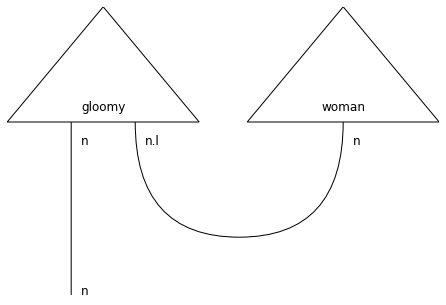

In [3]:
from discopy import Cup, Id, pregroup

grammar = Id(n) @ Cup(n.l, n)
sentence = gloomy @ woman >> grammar
pregroup.draw(sentence)

- Intransitive sentence

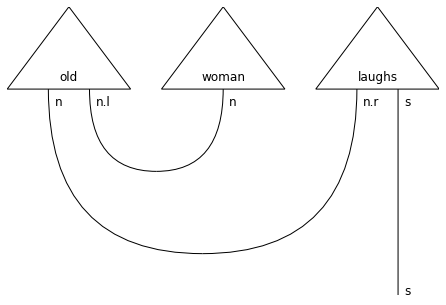

In [4]:
grammar =  Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s)
sentence = old @ woman @ laughs >> grammar
pregroup.draw(sentence)

- Transitive sentence

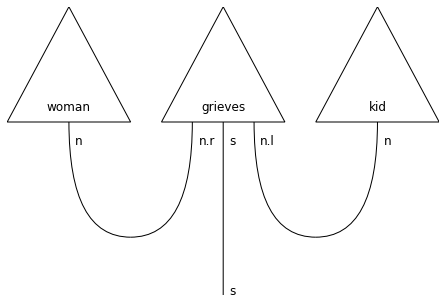

In [5]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
sentence = woman @ grieves @ kid >> grammar
pregroup.draw(sentence)

Now we have seen how the grammatical structure of each type of sentence is, so we are ready to obtain all the grammatical sentences that we can construct with them with the vocabulary that we are using. 

In [6]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary 

grammar_dict = {
    'ADJ_N' : Id(n) @ Cup(n.l, n),
    'ADJ_N_IV' : Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n)}
                                                                          

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)

data_psr = {}

# Attributive sentences
parsing_att = {"{} {}.".format(adj, noun): adj @ noun >> grammar_dict['ADJ_N']
            for adj in adjectives for noun in nouns}
sentences_att = list(parsing_att.keys())
for sentence in sentences_att:
    diagram = parsing_att[sentence]
    data_psr[sentence] = parsing_att[sentence]
    
# Intransitive sentences
parsing_int = {"{} {} {}.".format(adj, noun, int_verb): adj @ noun @ int_verb >> grammar_dict['ADJ_N_IV']
            for adj in adjectives for noun in nouns for int_verb in int_verbs}
sentences_int = list(parsing_int.keys())
for sentence in sentences_int:
    diagram = parsing_int[sentence]
    data_psr[sentence] = parsing_int[sentence]

# Transitive sentences
parsing_t = {"{} {} {}.".format(subj, t_verb, obj):  subj @ t_verb @ obj >> grammar_dict['N_TV_N']
            for subj in nouns for t_verb in t_verbs for obj in nouns}
sentences_t = list(parsing_t.keys())
for sentence in sentences_t:
    diagram = parsing_t[sentence]
    data_psr[sentence] = parsing_t[sentence]

Now, we have the dataset with the sentences and their corresponding meaning and grammar. The next step is to design the corresponding quantum circuits to determine the sentiment for each sentence. We are aiming to distinguish between four different emotions: happy (0), sad (1), angry (2), scared (3). However, some sentences of the dataset cannot be clearly classified according to this criteria (for example, 'Man is old'). Therefore, the next step is to manually modify the dataset so all the sentences can be classified according to this criteria. In order to do that we will create a .txt file and assign the corresponding class to the viable sentences.

In [7]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary 

grammar_dict = {
    'ADJ_N' : Id(n) @ Cup(n.l, n),
    'ADJ_N_IV' : Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n)}
                                                                          

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)
data_file = open('.data.txt', 'w')

# Attributive sentences
parsing_att = {"{} {}.".format(adj, noun): adj @ noun >> grammar_dict['ADJ_N']
            for adj in adjectives for noun in nouns}
sentences_att = list(parsing_att.keys())
for sentence in sentences_att:
    with open('./data.txt', 'a') as f:
        f.write(sentence + '_att \n')
    
# Intransitive sentences
parsing_int = {"{} {} {}.".format(adj, noun, int_verb): adj @ noun @ int_verb >> grammar_dict['ADJ_N_IV']
            for adj in adjectives for noun in nouns for int_verb in int_verbs}
sentences_int = list(parsing_int.keys())
for sentence in sentences_int:
    with open('./data.txt', 'a') as f:
        f.write(sentence + '_int \n')

# Transitive sentences
parsing_tra = {"{} {} {}.".format(subj, t_verb, obj):  subj @ t_verb @ obj >> grammar_dict['N_TV_N']
            for subj in nouns for t_verb in t_verbs for obj in nouns}
sentences_t = list(parsing_t.keys())
for sentence in sentences_t:
    with open('./data.txt', 'a') as f:
        f.write(sentence + '_tra \n')
        
data_file.close()

### 1.3. Processed the data

In [8]:
with open('processed_data.txt') as f:
    data = f.readlines()

In [9]:
labels_dict = {}
data_psr_dict = {}
sent_type = {}
for sentence in data:
    sentstr = sentence[:-7]
    if sentence[-6:-3] == 'att':
        diagram = parsing_att[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'att'
    elif sentence[-6:-3] == 'int':
        diagram = parsing_int[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'int'
    elif sentence[-6:-3] == 'tra':
        diagram = parsing_tra[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'tra'

In [10]:
c0 = 0
c1 = 0
c2 = 0
c3 = 0
for value in labels_dict.values():
    if value == '0':
        c0 +=1
    elif value == '1':
        c1 += 1
    elif value == '2':
        c2 += 1
    elif value == '3':
        c3 += 1
print('Number of elements for each sentiment')
print('Happy: ', c0)
print('Sad: ', c1)
print('Angry: ', c2)
print('Scared: ', c3)
print('Total', len(data_psr_dict))

Number of elements for each sentiment
Happy:  14
Sad:  24
Angry:  21
Scared:  27
Total 86


Now we have our dataset! The only problem left is the fact that the cups used in the diagrams are too resource consumming. Luckily, it is possible to remove them by transforming the states into effects (we are just doing this with the nouns as in https://github.com/CQCL/qnlp_lorenz_etal_2021_resources). Let us see some examples

- Attributive sentence

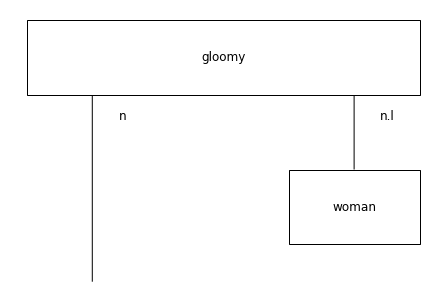

In [11]:
from discopy import Cap, Box
woman2 = Box('woman', n.l, Ty())
words_new = (Cap(n, n.l)) >> (gloomy) @ Id(n) @ woman2
sentence = words_new >> grammar_dict['ADJ_N']
sentence = sentence.normal_form()
sentence.draw()

- Intransitive sentence

In [12]:
woman2 = Box('woman', n.l, Ty())
words_new = (Cap(n, n.l)) >> (old @ Id(n) @ woman2 @ laughs)
sentence = words_new >> grammar_dict['ADJ_N_IV']
sentence = sentence.normal_form()

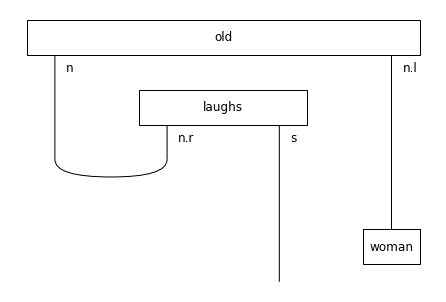

In [13]:
sentence.draw()

- Transitive sentence

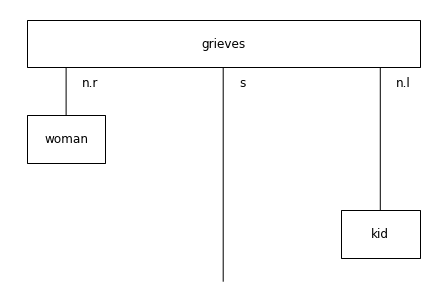

In [14]:
woman2 = Box('woman', n.r, Ty())
kid2 = Box('kid', n.l, Ty())
words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (woman2 @ Id(n) @ grieves @ Id(n) @ kid2)
sentence = words_new >> grammar_dict['N_TV_N']
sentence = sentence.normal_form()
sentence.draw()

Let us apply this to our entire dataset.

In [15]:
data_new_psr_dict = {}
for sentstr in data_psr_dict.keys():
    num_words = len(sentstr.split(' '))
    words = data_psr_dict[sentstr].boxes[:num_words]
    if sent_type[sentstr] == 'att':
        noun = Box(words[1].name, n.l, Ty())
        words_new = (Cap(n, n.l)) >> (words[0]) @ Id(n) @ noun
        sentence = words_new >> grammar_dict['ADJ_N']
        data_new_psr_dict[sentstr] = sentence.normal_form()
    elif sent_type[sentstr] == 'int':
        noun = Box(words[1].name, n.l, Ty())
        words_new = (Cap(n, n.l)) >> (words[0] @ Id(n) @ noun @ words[2])
        sentence = words_new >> grammar_dict['ADJ_N_IV']
        data_new_psr_dict[sentstr] = sentence.normal_form()
    elif sent_type[sentstr] == 'tra':
        noun1 = Box(words[0].name, n.r, Ty())
        noun2 = Box(words[2].name, n.l, Ty())
        words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
        sentence = words_new >> grammar_dict['N_TV_N']
        data_new_psr_dict[sentstr] = sentence.normal_form()

The final step before the implementation of the quantum circuit is to redefine the vocabulary according to the new domain and codamain for the nouns as effects.

In [16]:
vocab_psr = []
for word in vocab:
    if word.cod == Ty('n'):
        vocab_psr.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr.append(word)